In [1]:
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
library(car)
library(multcomp)
library(multcompView)
library(ggpubr)

theme_set(ggthemes::theme_few() + theme(text = element_text(size = 14), strip.text = element_text(size = 14), plot.title = element_text(size = 14, hjust = 0.5)))

options(repr.plot.width=5, repr.plot.height=5)
myColorPalette <- c("#005AB5","#DC3220")

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack



Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:dplyr':

    recode


The following object is masked from 

In [2]:
# Helper function to check model assumptions   
check_assumptions <- function(mod) {

   print(plot(mod)) # resid x pred
   print(plot(density(resid(mod))))  #A density plot
   # Make sure the residuals are normal
   shapiro.test(residuals(mod)) 
}

In [3]:
pb <- read.csv("./datasets/pivot_bio_trials.csv") %>% 
#mutate(state = substr(site,1,2)) %>% 
filter(keep_flag)

head(pb)

pb <- pb %>% mutate_at(c("year","rep","treatment","plot"), factor)
pb$treatment <- factor(pb$treatment, levels = c('UTC','PROVEN40'))

,year,site,rep,plot,treatment,keep_flag,d15n_leaftip
,<int>,<chr>,<int>,<int>,<chr>,<lgl>,<dbl>
1,2021,IA01401,1,101,PROVEN40,TRUE,2.999752
2,2021,IA01401,1,104,UTC,TRUE,3.129368
3,2021,IA01401,2,202,UTC,TRUE,2.606789
4,2021,IA01401,2,205,PROVEN40,TRUE,2.260991
5,2021,IA01401,3,305,UTC,TRUE,3.279558
6,2021,IA01401,3,308,PROVEN40,TRUE,2.790926


In [4]:
# test for HOV across treatments
leveneTest(d15n_leaftip ~ treatment, data=pb)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,1,1.28724,0.2587281
,125,NA,NA


In [5]:
pb_mod1 <- lmer(d15n_leaftip ~ treatment  + (1|site/rep), data = pb)

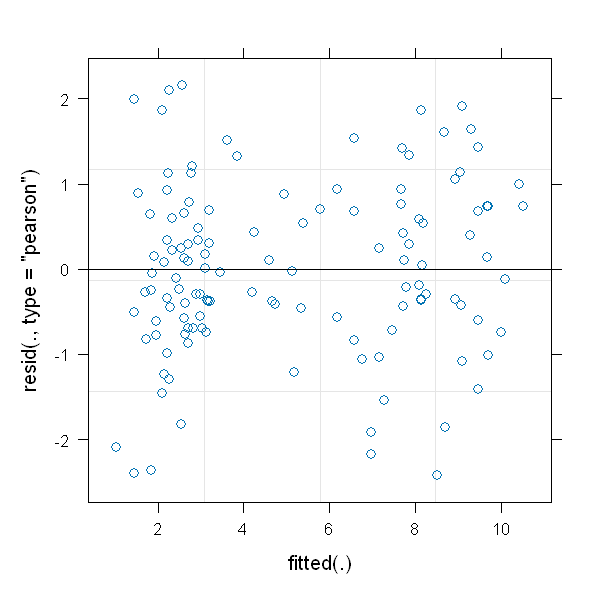

NULL



	Shapiro-Wilk normality test

data:  residuals(mod)
W = 0.98835, p-value = 0.3574


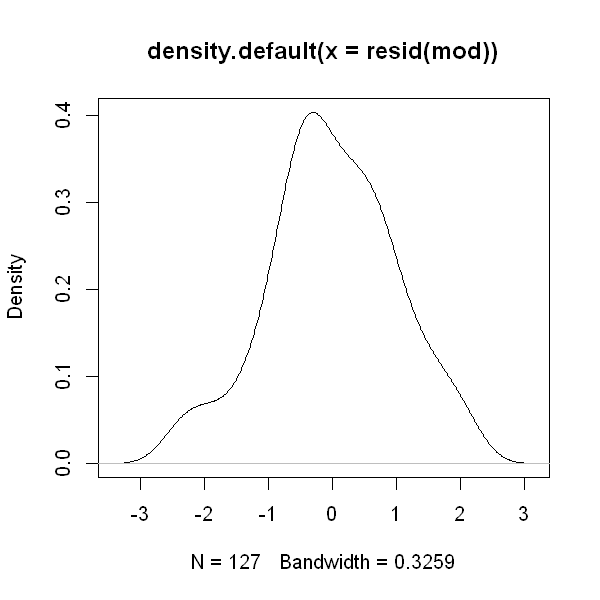

In [6]:
check_assumptions(pb_mod1)

In [7]:
summary(pb_mod1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: d15n_leaftip ~ treatment + (1 | site/rep)
   Data: pb

REML criterion at convergence: 467.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1207 -0.5216 -0.0215  0.5986  1.8880 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep:site (Intercept) 0.3319   0.5761  
 site     (Intercept) 7.5679   2.7510  
 Residual             1.3026   1.1413  
Number of obs: 127, groups:  rep:site, 52; site, 16

Fixed effects:
                  Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)         5.3735     0.7111 15.6801   7.556 1.31e-06 ***
treatmentPROVEN40  -0.4041     0.2096 77.2984  -1.928   0.0576 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
trtPROVEN40 -0.131

In [8]:
pb_mod1_mod_means <- emmeans(pb_mod1, ~ treatment,  type = "response")
pb_mod1_mod_means

 treatment emmean    SE   df lower.CL upper.CL
 UTC         5.37 0.711 15.5     3.86     6.88
 PROVEN40    4.97 0.715 15.8     3.45     6.49

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

In [9]:
as.data.frame(pb_mod1_mod_means) 

,treatment,emmean,SE,df,lower.CL,upper.CL
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,UTC,5.373460,0.7112069,15.51695,3.861945,6.884975
2,PROVEN40,4.969341,0.7145625,15.81669,3.453108,6.485574


In [10]:
x <- summary(pb_mod1)$coefficients

my_label <- paste0(
    "Ndfa = ",signif(-100*x[2,1]/x[1,1],2),"%\n",
    "p = ",signif(x[2,5],2)
    )


In [11]:
my_label

[1] "Ndfa = 7.5%\np = 0.058"

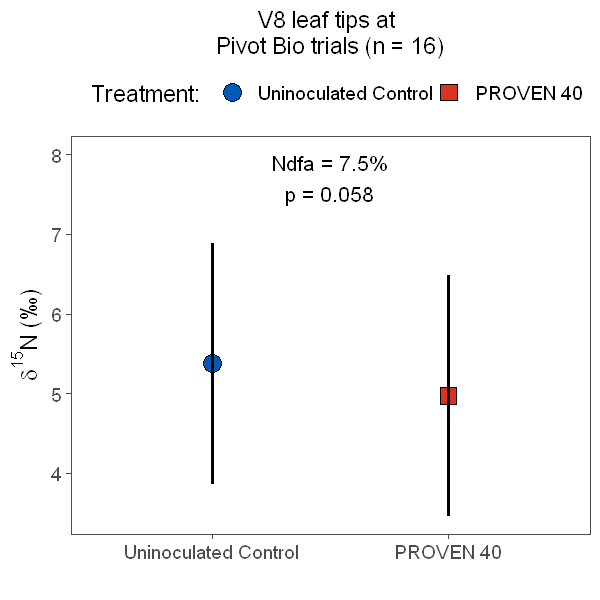

In [12]:
pb_mod1_plot <- as.data.frame(pb_mod1_mod_means) %>% 
ggplot(aes(treatment,emmean, fill = treatment)) + 
#geom_point(aes(y = d15n_leaftip, colour = treatment, fill = treatment), data = pb, position = position_dodge(width = 0.4), size = 1 ) +
geom_point(size = 5, aes(shape = treatment)) + 
geom_errorbar(aes(ymax = upper.CL, ymin = lower.CL), width = 0, lwd = 1) + 
#geom_errorbar(aes(ymax = emmean + SE, ymin = emmean - SE), width = 0, lwd = 3) + 
annotate("text", y = 8, x = 1.5, label = my_label, vjust = 1, size = 4.5) +
theme(legend.position = "top") +
scale_shape_manual(values = c(21,22),  labels = c("Uninoculated Control","PROVEN 40")) + 
scale_fill_manual(values = myColorPalette, labels = c("Uninoculated Control","PROVEN 40")) +
labs(y = expression(delta^15*N~"(‰)"), x = "", title = "V8 leaf tips at \nPivot Bio trials (n = 16)", fill = "Treatment:", shape = "Treatment:") + 
scale_x_discrete(labels = c("Uninoculated Control","PROVEN 40")) 

pb_mod1_plot

In [13]:
saveRDS(pb_mod1_plot, "./figures/pb_leaftip_natural_abundance.rds")